## Análisis Matemático para Inteligencia Artificial

### Grupo 3

| Autores               | E-mail                    | Nº SIU  |
|---------------------- |---------------------------|---------|
| Leonardo Centurión    | centurionm.leo@gmail.com  | a1803   |
| Braian Desía          | b.desia@hotmail.com       | a1804   |
| Juan José Cardinali   | juanchijc@gmail.com       | a1809   |
| Rodrigo Meza          | rodrigolx31@gmail.com     | a1815   |
| Juan Ramos Nervi      | jern10@gmail.com          | a1821   |

# Trabajo Práctico Final: Linear/Quadratic Discriminant Analysis (LDA/QDA)

### Definición: Clasificador Bayesiano

Sean $k$ poblaciones, $x \in \mathbb{R}^p$ puede pertenecer a cualquiera $g \in \mathcal{G}$ de ellas. Bajo un esquema bayesiano, se define entonces $\pi_j \doteq P(G = j)$ la probabilidad *a priori* de que $X$ pertenezca a la clase *j*, y se **asume conocida** la distribución condicional de cada observable dado su clase $f_j \doteq f_{X|G=j}$.

De esta manera dicha probabilidad *a posteriori* resulta
$$
P(G|_{X=x} = j) = \frac{f_{X|G=j}(x) \cdot p_G(j)}{f_X(x)} \propto f_j(x) \cdot \pi_j
$$

La regla de decisión de Bayes es entonces
$$
H(x) \doteq \arg \max_{g \in \mathcal{G}} \{ P(G|_{X=x} = j) \} = \arg \max_{g \in \mathcal{G}} \{ f_j(x) \cdot \pi_j \}
$$

es decir, se predice a $x$ como perteneciente a la población $j$ cuya probabilidad a posteriori es máxima.

*Ojo, a no desesperar! $\pi_j$ no es otra cosa que una constante prefijada, y $f_j$ es, en su esencia, un campo escalar de $x$ a simplemente evaluar.*

### Distribución condicional

Para los clasificadores de discriminante cuadrático y lineal (QDA/LDA) se asume que $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma_j)$, es decir, se asume que cada población sigue una distribución normal.

Por definición, se tiene entonces que para una clase $j$:
$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Aplicando logaritmo (que al ser una función estrictamente creciente no afecta el cálculo de máximos/mínimos), queda algo mucho más práctico de trabajar:

$$
\log{f_j(x)} = -\frac{1}{2}\log |\Sigma_j| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Observar que en este caso $C=-\frac{p}{2} \log(2\pi)$, pero no se tiene en cuenta ya que al tener una constante aditiva en todas las clases, no afecta al cálculo del máximo.

### LDA

En el caso de LDA se hace una suposición extra, que es $X|_{G=j} \sim \mathcal{N}_p(\mu_j, \Sigma)$, es decir que las poblaciones no sólo siguen una distribución normal sino que son de igual matriz de covarianzas. Reemplazando arriba se obtiene entonces:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

Ahora, como $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases se puede incorporar a la constante aditiva y, distribuyendo y reagrupando términos sobre $(x-\mu_j)^T \Sigma^{-1} (x- \mu_j)$ se obtiene finalmente:

$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$

### Entrenamiento/Ajuste

Obsérvese que para ambos modelos, ajustarlos a los datos implica estimar los parámetros $(\mu_j, \Sigma_j) \; \forall j = 1, \dots, k$ en el caso de QDA, y $(\mu_j, \Sigma)$ para LDA.

Estos parámetros se estiman por máxima verosimilitud, de manera que los estimadores resultan:

* $\hat{\mu}_j = \bar{x}_j$ el promedio de los $x$ de la clase *j*
* $\hat{\Sigma}_j = s^2_j$ la matriz de covarianzas estimada para cada clase *j*
* $\hat{\pi}_j = f_{R_j} = \frac{n_j}{n}$ la frecuencia relativa de la clase *j* en la muestra
* $\hat{\Sigma} = \frac{1}{n} \sum_{j=1}^k n_j \cdot s^2_j$ el promedio ponderado (por frecs. relativas) de las matrices de covarianzas de todas las clases. *Observar que se utiliza el estimador de MV y no el insesgado*

Es importante notar que si bien todos los $\mu, \Sigma$ deben ser estimados, la distribución *a priori* puede no inferirse de los datos sino asumirse previamente, utilizándose como entrada del modelo.

### Predicción

Para estos modelos, al igual que para cualquier clasificador Bayesiano del tipo antes visto, la estimación de la clase es por método *plug-in* sobre la regla de decisión $H(x)$, es decir devolver la clase que maximiza $\hat{f}_j(x) \cdot \hat{\pi}_j$, o lo que es lo mismo $\log\hat{f}_j(x) + \log\hat{\pi}_j$.

## Estructura del código

In [1]:
## Modelo

In [2]:
import timeit

import numpy as np
import pandas as pd
from numpy.linalg import det, inv
from sklearn.datasets import load_iris, fetch_openml
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [3]:
class ClassEncoder:
  def fit(self, y):
    self.names = np.unique(y)
    self.name_to_class = {name:idx for idx, name in enumerate(self.names)}
    self.fmt = y.dtype
    # Q1: por que no hace falta definir un class_to_name para el mapeo inverso?

  def _map_reshape(self, f, arr):
    return np.array([f(elem) for elem in arr.flatten()]).reshape(arr.shape)
    # Q2: por que hace falta un reshape?

  def transform(self, y):
    return self._map_reshape(lambda name: self.name_to_class[name], y)

  def fit_transform(self, y):
    self.fit(y)
    return self.transform(y)

  def detransform(self, y_hat):
    return self._map_reshape(lambda idx: self.names[idx], y_hat)

In [4]:
class BaseBayesianClassifier:
  def __init__(self):
    self.encoder = ClassEncoder()

  def _estimate_a_priori(self, y):
    a_priori = np.bincount(y.flatten().astype(int)) / y.size
    # Q3: para que sirve bincount?
    return np.log(a_priori)

  def _fit_params(self, X, y):
    # estimate all needed parameters for given model
    raise NotImplementedError()

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    raise NotImplementedError()

  def fit(self, X, y, a_priori=None):
    # first encode the classes
    y = self.encoder.fit_transform(y)
    # if it's needed, estimate a priori probabilities
    self.log_a_priori = self._estimate_a_priori(y) if a_priori is None else np.log(a_priori)

    # check that a_priori has the correct number of classes
    assert len(self.log_a_priori) == len(self.encoder.names), "A priori probabilities do not match number of classes"

    # now that everything else is in place, estimate all needed parameters for given model
    self._fit_params(X, y)
    # Q4: por que el _fit_params va al final? no se puede mover a, por ejemplo, antes de la priori?

  def predict(self, X):
    # this is actually an individual prediction encased in a for-loop
    m_obs = X.shape[1]
    y_hat = np.empty(m_obs, dtype=self.encoder.fmt)

    for i in range(m_obs):
      encoded_y_hat_i = self._predict_one(X[:,i].reshape(-1,1))
      y_hat[i] = self.encoder.names[encoded_y_hat_i]

    # return prediction as a row vector (matching y)
    return y_hat.reshape(1,-1)

  def _predict_one(self, x):
    # calculate all log posteriori probabilities (actually, +C)
    log_posteriori = [ log_a_priori_i + self._predict_log_conditional(x, idx) for idx, log_a_priori_i
                  in enumerate(self.log_a_priori) ]

    # return the class that has maximum a posteriori probability
    return np.argmax(log_posteriori)

class QDA(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    # estimate each covariance matrix
    self.inv_covs = [inv(np.cov(X[:, y.flatten() == class_i], bias=True))
                     for class_i in range(len(self.log_a_priori))]
    # Q5: por que hace falta el flatten y no se puede directamente X[:,y==idx]?
    # Q6: por que se usa bias=True en vez del default bias=False?
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]
    # Q7: que hace axis=1? por que no axis=0?

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    inv_cov = self.inv_covs[class_idx]
    unbiased_x =  x - self.means[class_idx]
    return 0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x

class TensorizedQDA(QDA):
    def _fit_params(self, X, y):
        # ask plain QDA to fit params
        super()._fit_params(X,y)

        # stack onto new dimension
        self.tensor_inv_cov = np.stack(self.inv_covs)
        self.tensor_means = np.stack(self.means)

    def _predict_log_conditionals(self, x):
        unbiased_x = x - self.tensor_means
        inner_prod = unbiased_x.transpose(0,2,1) @ self.tensor_inv_cov @ unbiased_x

        return 0.5*np.log(det(self.tensor_inv_cov)) - 0.5 * inner_prod.flatten()

    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x))



## Código para pruebas

Seteamos los datos

In [5]:
# hiperparámetros
rng_seed = 6543

In [6]:
from sklearn.datasets import load_iris, fetch_openml

def get_iris_dataset():
  data = load_iris()
  X_full = data.data
  y_full = np.array([data.target_names[y] for y in data.target.reshape(-1,1)])
  return X_full, y_full

def get_penguins():
    # get data
    df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')

    # drop non-numeric columns
    df.drop(columns=["island","sex"], inplace=True)

    # drop rows with missing values
    mask = df.isna().sum(axis=1) == 0
    df = df[mask]
    tgt = tgt[mask]

    return df.values, tgt.to_numpy().reshape(-1,1)

# showing for iris
X_full, y_full = get_iris_dataset()

print(f"X: {X_full.shape}, Y:{y_full.shape}")

X: (150, 4), Y:(150, 1)


In [7]:
# peek data matrix
X_full[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [8]:
# peek target vector
y_full[:5]

array([['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa'],
       ['setosa']], dtype='<U10')

Separamos el dataset en train y test para medir performance

In [9]:
# preparing data, train - test validation
# 60-40 split
from sklearn.model_selection import train_test_split

def split_transpose(X, y, test_sz, random_state):
    # split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_sz, random_state=random_state)

    # transpose so observations are column vectors
    return X_train.T, y_train.T, X_test.T, y_test.T

def accuracy(y_true, y_pred):
  return (y_true == y_pred).mean()

train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, rng_seed)

print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

(4, 90) (1, 90) (4, 60) (1, 60)


Entrenamos un QDA y medimos su accuracy

In [10]:
qda = QDA()

qda.fit(train_x, train_y)

In [11]:
train_acc = accuracy(train_y, qda.predict(train_x))
test_acc = accuracy(test_y, qda.predict(test_x))
print(f"Train (apparent) error is {1-train_acc:.4f} while test error is {1-test_acc:.4f}")

Train (apparent) error is 0.0111 while test error is 0.0167


Con el magic %%timeit podemos estimar el tiempo que tarda en correr una celda en base a varias ejecuciones. Por poner un ejemplo, acá vamos a estimar lo que tarda un ciclo completo de QDA y también su inferencia (predicción).

Ojo! a veces [puede ser necesario ejecutarlo varias veces](https://stackoverflow.com/questions/10994405/python-timeit-results-cached-instead-of-calculated) para obtener resultados consistentes.

Si quieren explorar otros métodos de medición también es válido!

# Consigna


## Implementación base
1. Entrenar un modelo QDA sobre el dataset *iris* utilizando las distribuciones *a priori* a continuación ¿Se observan diferencias?¿Por qué cree? _Pista: comparar con las distribuciones del dataset completo, **sin splitear**_.
    1. Uniforme (cada clase tiene probabilidad 1/3)
    2. Una clase con probabilidad 0.9, las demás 0.05 (probar las 3 combinaciones)
2. Repetir el punto anterior para el dataset *penguin*.
3. Implementar el modelo LDA, entrenarlo y testearlo contra los mismos sets que QDA (no múltiples prioris) ¿Se observan diferencias? ¿Podría decirse que alguno de los dos es notoriamente mejor que el otro?
4. Utilizar otros 2 (dos) valores de *random seed* para obtener distintos splits de train y test, y repetir la comparación del punto anterior ¿Las conclusiones previas se mantienen?
5. Estimar y comparar los tiempos de predicción de las clases `QDA` y `TensorizedQDA`. De haber diferencias ¿Cuáles pueden ser las causas?


**Sugerencia:** puede resultar de utilidad para cada inciso de comparación utilizar tablas del siguiente estilo:

<center>

Modelo | Dataset | Seed | Error (train) | Error (test)
:---: | :---: | :---: | :---: | :---:
QDA | Iris | 125 | 0.55 | 0.85
LDA | Iris | 125 | 0.22 | 0.8

</center>


#### Resolución

Pre-procesamiento y análisis de datos del dataset **IRIS**

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  


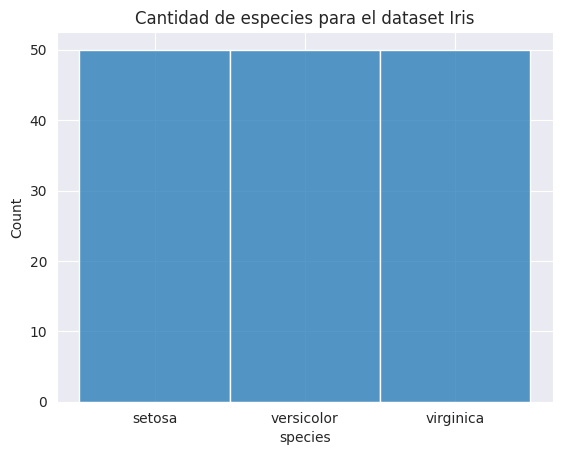

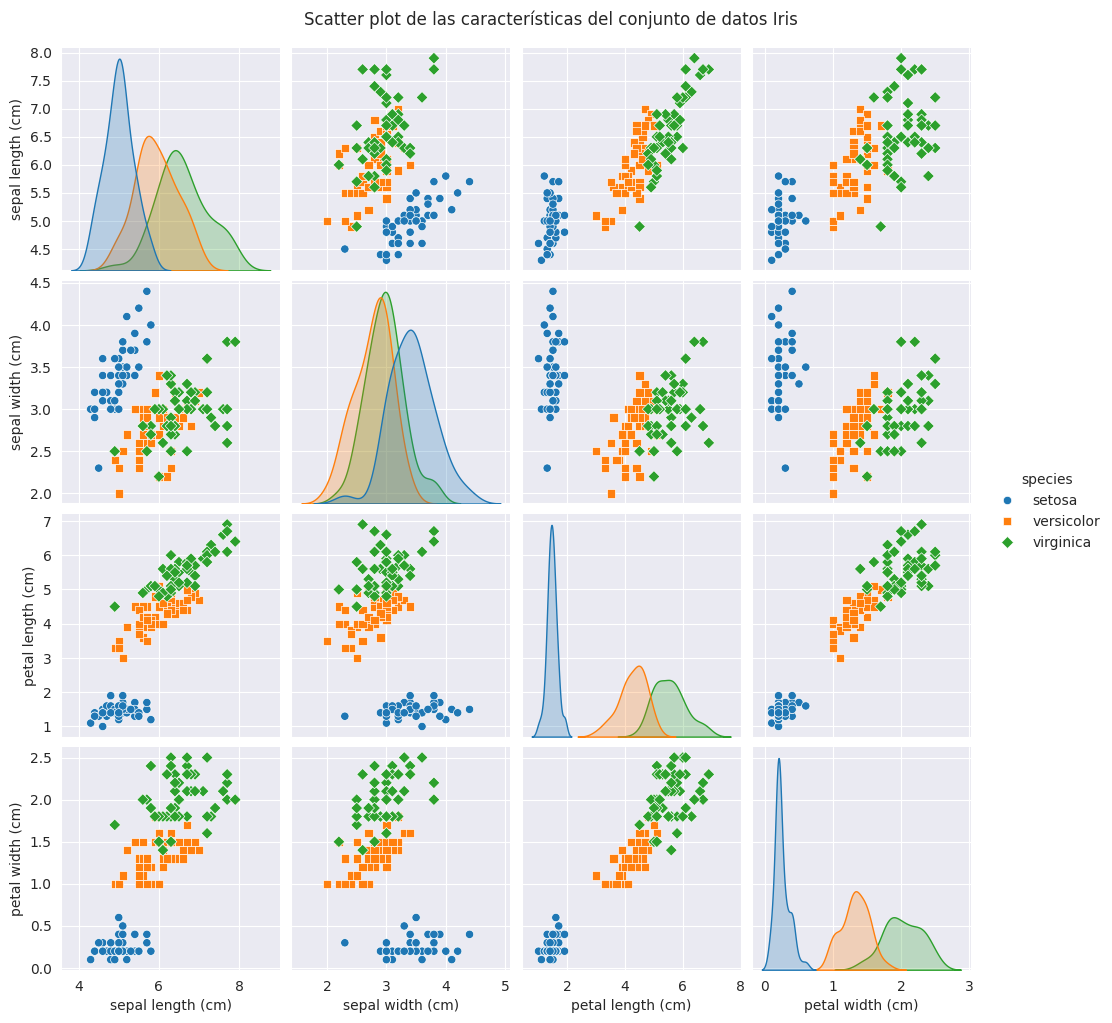

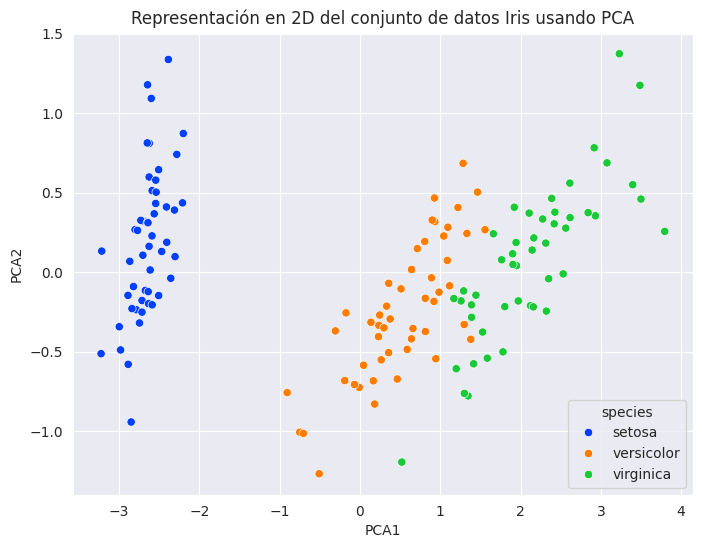

In [12]:
data = load_iris()

# Crear un DataFrame para facilidad de uso
df = pd.DataFrame(data.data, columns=data.feature_names)
df['species'] = pd.Categorical.from_codes(data.target, data.target_names)

# Mostrar las primeras filas del DataFrame para tener una idea
print(df.head())

sns.histplot(data=df, x='species')
plt.title("Cantidad de especies para el dataset Iris")

# Gráfico de dispersión (pairplot)
sns.pairplot(df, hue='species', markers=["o", "s", "D"])
plt.suptitle("Scatter plot de las características del conjunto de datos Iris", y=1.02)
plt.show()

# Gráfico en 2D con reducción de dimensionalidad usando PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(data.data)

# Crear un DataFrame con los datos de PCA
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['species'] = df['species']

# Graficar los resultados de PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='species', data=df_pca, palette='bright')
plt.title("Representación en 2D del conjunto de datos Iris usando PCA")
plt.show()

##### ALGUNAS OBSERVACIONES:

- Las tres especiese se encuentran uniformemente distribuidas en el dateset completo.

- Se observa una correlación positiva entre longitud de petalo `petal length` y ancho de petalo `petal width`, es decir, a mayor longitud, mayor tamaño. También queda claramente diferenciadas las diferentes especias por los valores de estos atributos. Se tiene en orden ascendente: setosa, versicolor, virginica.

- Se observa una correlación inversa entre los atributs longitud de sepalo `sepal length` y ancho de sepalo `sepal width`.

- Se observa una correlación positiva entre los atributos longitud de sepalo `sepal length` con longitud de petalo `petal length` y ancho de petalo `petal width`. 

- En términos generales, podemos ver que los atributos reportados se diferencian según el tipo de especies.

- Se observan distribuciones de los atributos del tipo normales o gaussianas.

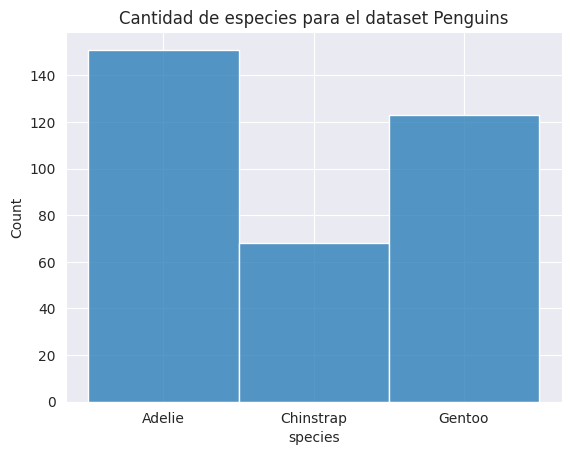

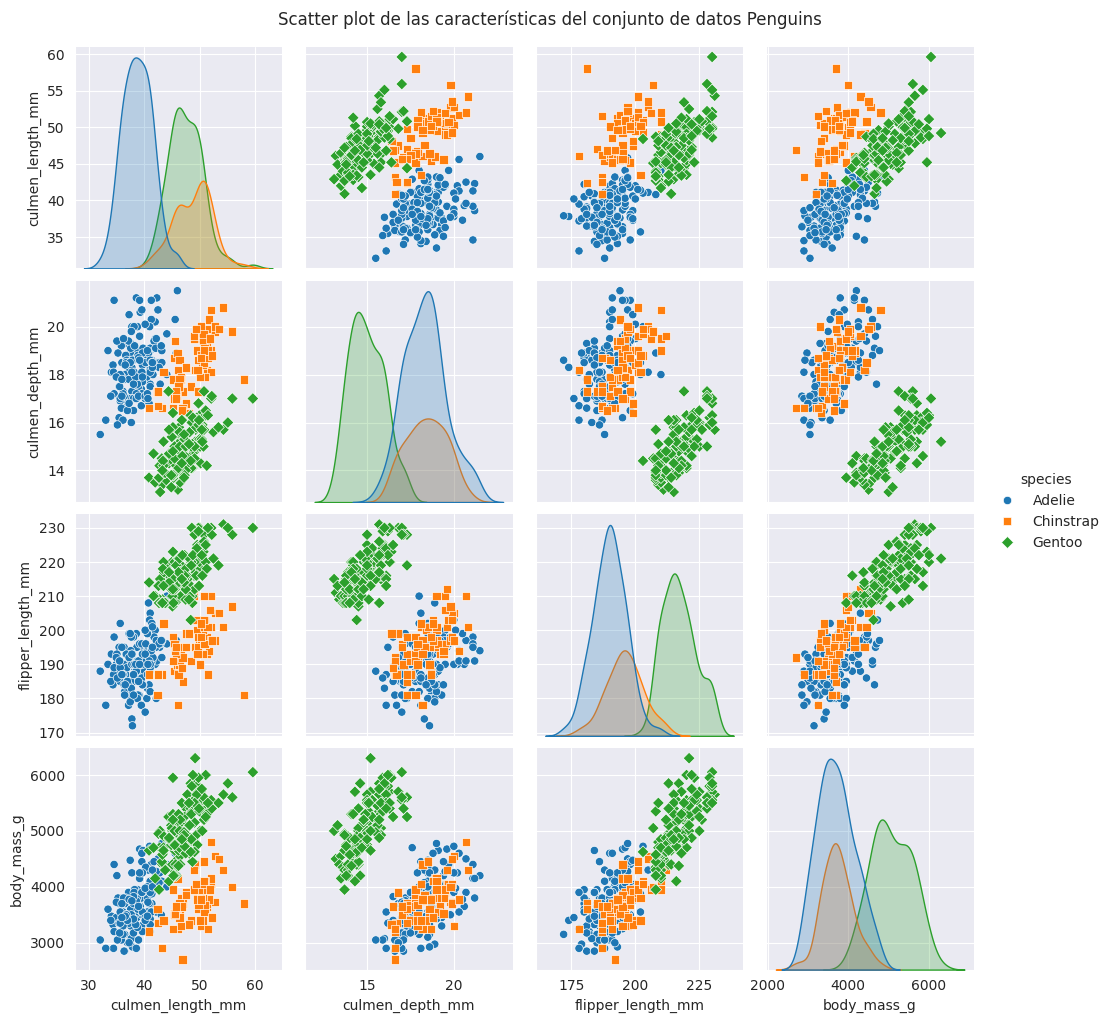

In [13]:
df, tgt = fetch_openml(name="penguins", return_X_y=True, as_frame=True, parser='auto')

# Eliminar columnas no numéricas y filas con valores faltantes
df.drop(columns=["island", "sex"], inplace=True)
mask = df.isna().sum(axis=1) == 0
df = df[mask]
tgt = tgt[mask]

# Añadir la columna de especies al DataFrame
df['species'] = tgt

sns.histplot(data=df, x='species')
plt.title("Cantidad de especies para el dataset Penguins")

# Gráfico de dispersión (pairplot)
sns.pairplot(df, hue='species', markers=["o", "s", "D"])
plt.suptitle("Scatter plot de las características del conjunto de datos Penguins", y=1.02)
plt.show()


##### ALGUNAS OBSERVACIONES:

- Las tres clases no presentan una distribución uniforme en el dataset completo. En orden descendente: `Adelie`, `Gentoo`, `Chinstrap species`.

- Se observa una correlación positiva entre longitud de ala `flipper length` y masa ` body mass`, es decir, a mayor longitud de ala, mayor masa del pinguino.

- Se observa una correlación inversa entre los atributos `culmen depth` con masa ` body mass` y longitud de ala `flipper length`.

- Se observan distribuciones de los atributos del tipo normales o gaussianas.

Implementación del método LDA y auxiliares para corridas en *batch*

In [14]:

class LDA(BaseBayesianClassifier):
  def _fit_params(self, X, y):
    # estimate WEIGHTED AVERAGE covariance matrix
    class_count = lambda c: len(X[:, y.flatten() == c])
    total = float(len(X))
    self.inv_covs = inv(sum([class_count(class_i) * np.cov(X[:, y.flatten() == class_i], bias = True)
                     for class_i in range(len(self.log_a_priori))])/total)
    self.means = [X[:,y.flatten()==idx].mean(axis=1, keepdims=True)
                  for idx in range(len(self.log_a_priori))]

  def _predict_log_conditional(self, x, class_idx):
    # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
    # this should depend on the model used
    return self.means[class_idx].T @ self.inv_covs @ (x - 0.5 * self.means[class_idx])


In [15]:
class ModelRun:
    def __init__(self, model, test_sz, seed, a_priori, dataset_provider):
        self.test_acc = None
        self.train_acc = None
        self.dataset_provider = dataset_provider
        self.a_priori = a_priori
        self.test_sz = test_sz
        self.seed = seed
        self.model = model
    def apply(self):
        x_full, y_full = self.dataset_provider()
        train_x, train_y, test_x, test_y = split_transpose(x_full, y_full, self.test_sz, self.seed)
    
        model = self.model()
        model.fit(train_x, train_y, a_priori=self.a_priori)
        self.train_acc = accuracy(train_y, model.predict(train_x))
        self.test_acc = accuracy(test_y, model.predict(test_x))
        return self
    
    def report(self):
        return {
            "Modelo": format(self.model),
            "Dataset": format(self.dataset_provider),
            "A Priori": format(self.a_priori),
            "Seed": self.seed,
            "Error(train)": 1.0 - self.train_acc,
            "Error(test)": 1.0 - self.test_acc
        }

test_sz = 0.40    
runs = []
runs.append(ModelRun(QDA, test_sz, rng_seed, None, get_iris_dataset))
runs.append(ModelRun(QDA, test_sz, rng_seed, [0.33,0.33,0.33], get_iris_dataset))
for i in range(3):
    a_priori=np.repeat(0.05,3)
    a_priori[i] = 0.90
    runs.append(ModelRun(QDA, test_sz, rng_seed, a_priori, get_iris_dataset))

runs.append(ModelRun(QDA, test_sz, rng_seed, None, get_penguins))
runs.append(ModelRun(QDA, test_sz, rng_seed, [0.33,0.33,0.33], get_penguins))
for i in range(3):
    a_priori=np.repeat(0.05,3)
    a_priori[i] = 0.90
    runs.append(ModelRun(QDA, test_sz, rng_seed, a_priori, get_penguins))

class ModelRun:
    def __init__(self, model, test_sz, seed, a_priori, dataset_provider):
        self.test_acc = None
        self.train_acc = None
        self.dataset_provider = dataset_provider
        self.test_sz = test_sz
        self.a_priori = a_priori
        self.seed = seed
        self.model_class = model

    def run(self):
        model, test_x, test_y, train_x, train_y = self.fit()
        self.train_acc = accuracy(train_y, model.predict(train_x))
        self.test_acc = accuracy(test_y, model.predict(test_x))
        return self

    def fit(self):
        x_full, y_full = self.dataset_provider()
        train_x, train_y, test_x, test_y = split_transpose(x_full, y_full, self.test_sz, rng_seed)
        model = self.model_class()
        model.fit(train_x, train_y, a_priori=self.a_priori)
        return model, test_x, test_y, train_x, train_y

    def report(self):
        return {
            "Modelo": format(self.model_class.__name__),
            "Dataset": format(self.dataset_provider.__name__),
            "A Priori": format(self.a_priori),
            "Test_size": self.test_sz,
            "Seed": self.seed,
            "Error(train)": 1.0 - self.train_acc,
            "Error(test)": 1.0 - self.test_acc
        }

runs = []
def add_model(model, test_sz, seed, dataset):
    runs = []
    runs.append(ModelRun(model, test_sz, seed, None, dataset))
    runs.append(ModelRun(model, test_sz, seed, [0.33, 0.33, 0.33], dataset))
    for i in range(3):
        a_priori = np.repeat(0.05, 3)
        a_priori[i] = 0.90
        runs.append(ModelRun(model, test_sz, seed, a_priori, dataset))
    return runs

runs += add_model(QDA, test_sz, rng_seed, get_iris_dataset)
runs += add_model(QDA, test_sz, rng_seed, get_penguins)

runs += add_model(LDA, test_sz, rng_seed, get_iris_dataset)
runs += add_model(LDA, test_sz, rng_seed, get_penguins)

# Same but with different seeds
other_seeds = [1, 42]
for seed in other_seeds:
    for method_da in [QDA,LDA]:
        runs += add_model(method_da, test_sz, seed, get_iris_dataset)
        runs += add_model(method_da, test_sz, seed, get_penguins)

model_runs_result = pd.DataFrame([run.run().report() for run in runs])
model_runs_result

,Modelo,Dataset,A Priori,Test_size,Seed,Error(train),Error(test)
0,QDA,get_iris_dataset,None,0.4,6543,0.011111,0.016667
1,QDA,get_iris_dataset,"[0.33, 0.33, 0.33]",0.4,6543,0.022222,0.016667
2,QDA,get_iris_dataset,[0.9 0.05 0.05],0.4,6543,0.022222,0.016667
3,QDA,get_iris_dataset,[0.05 0.9 0.05],0.4,6543,0.033333,0.000000
4,QDA,get_iris_dataset,[0.05 0.05 0.9 ],0.4,6543,0.033333,0.050000
5,QDA,get_penguins,None,0.4,6543,0.014634,0.014599
6,QDA,get_penguins,"[0.33, 0.33, 0.33]",0.4,6543,0.009756,0.007299
7,QDA,get_penguins,[0.9 0.05 0.05],0.4,6543,0.019512,0.021898
8,QDA,get_penguins,[0.05 0.9 0.05],0.4,6543,0.009756,0.021898
9,QDA,get_penguins,[0.05 0.05 0.9 ],0.4,6543,0.009756,0.007299


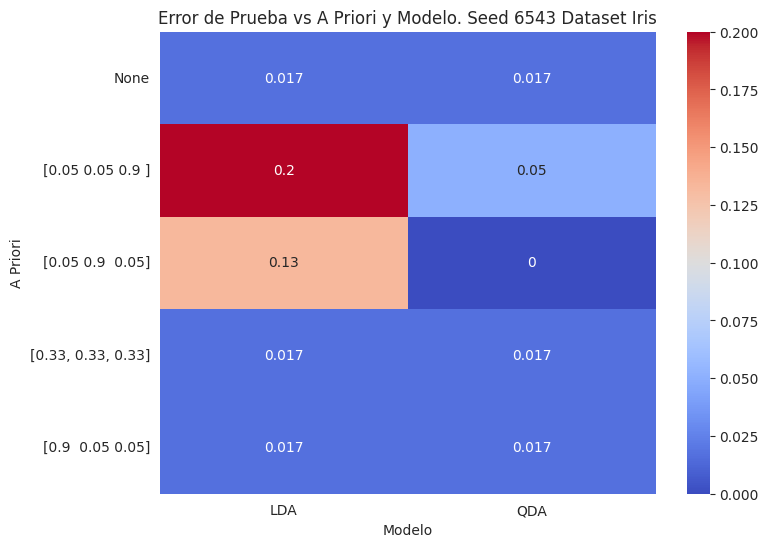

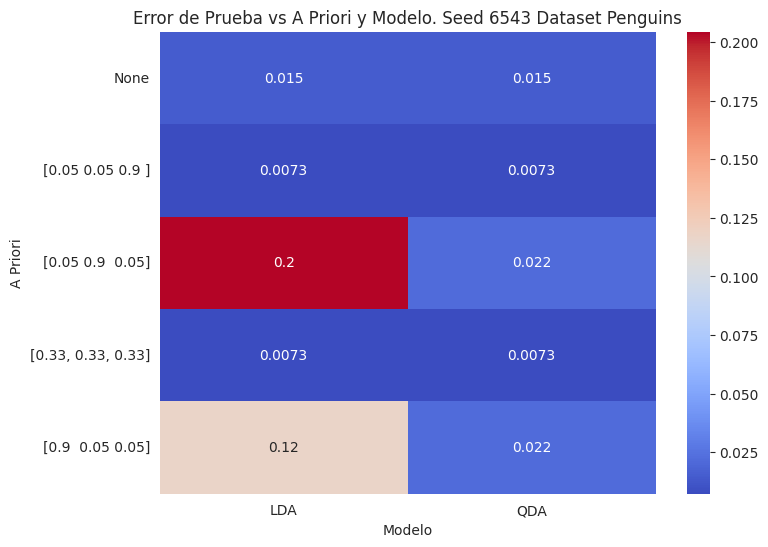

In [16]:
# Convertir los valores de A Priori a cadena para el heatmap
model_runs_result['A Priori'] = model_runs_result['A Priori'].astype(str)

# Crear la matriz pivote para el heatmap
seed = rng_seed
results_penguins_04 = model_runs_result[(model_runs_result['Seed'] == seed) & (model_runs_result['Dataset'] == 'get_iris_dataset')]

heatmap_data = results_penguins_04.pivot_table(values='Error(test)', index='A Priori', columns='Modelo')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title(f"Error de Prueba vs A Priori y Modelo. Seed {seed} Dataset Iris")
plt.show()

# Convertir los valores de A Priori a cadena para el heatmap
model_runs_result['A Priori'] = model_runs_result['A Priori'].astype(str)

# Crear la matriz pivote para el heatmap
results_penguins_04 = model_runs_result[(model_runs_result['Seed'] == seed) & (model_runs_result['Dataset'] == 'get_penguins')]

heatmap_data = results_penguins_04.pivot_table(values='Error(test)', index='A Priori', columns='Modelo')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title(f"Error de Prueba vs A Priori y Modelo. Seed {seed} Dataset Penguins")
plt.show()

#### OBSERVACIONES PUNTOS 1, 2 3 3

- Para el dataset de iris se observa que dando un 90% de probabilidad a priori a la especie versicolor el error de test resulta 0 lo cual es mejor a los 0.017 del a priori calculado a partir del dataset de entrenamiento. Sin embargo dando un 90% de a priori a Virginica se empeora la prediccion con un error de 0.05. Esto llama la atencion ya que las especies del dataset tienen la misma frecuencia.

- Para el dataset de penguins se observa que la distribuccion uniforme y un a priori de 90% para la especie Gentoo dejan el error en 0.0073, lo cual es una mejora con respecto a los 0.015 calculados a partir del set de testeo.

- La performance de la predicción de ambos clasificadores es dependiente del *a priori*, por lo cual se observan diferencias entre los distitos *a prioris*, como se desprende de los comentarios de más arriba.

- Se observa que, con un buen *a priori*, ambos modelos tienen una *performance* similar (véase, p.ej., caso [0.05 0.05 0.9] para el dataset *penguins*), pero cuando el *a priori* no es tan bueno, QDA arroja mejores resultados en términos de error (véase, p.ej., caso [0.05 0.9 0.05] para el dataset *penguins*).


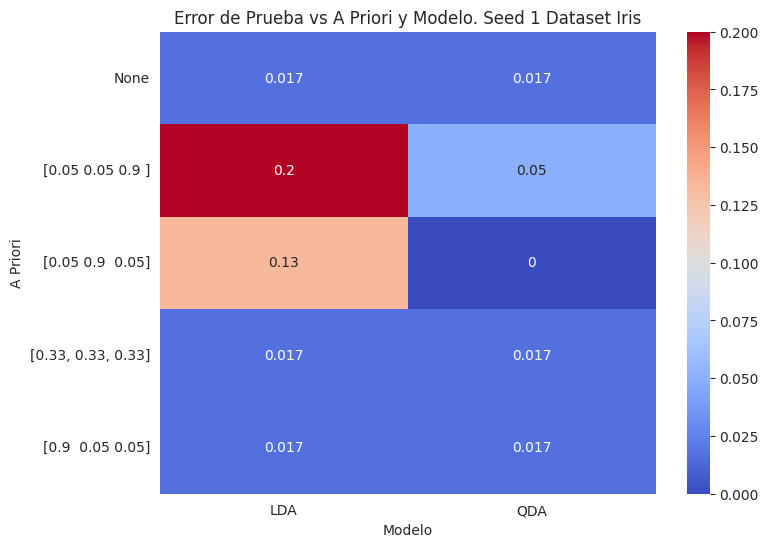

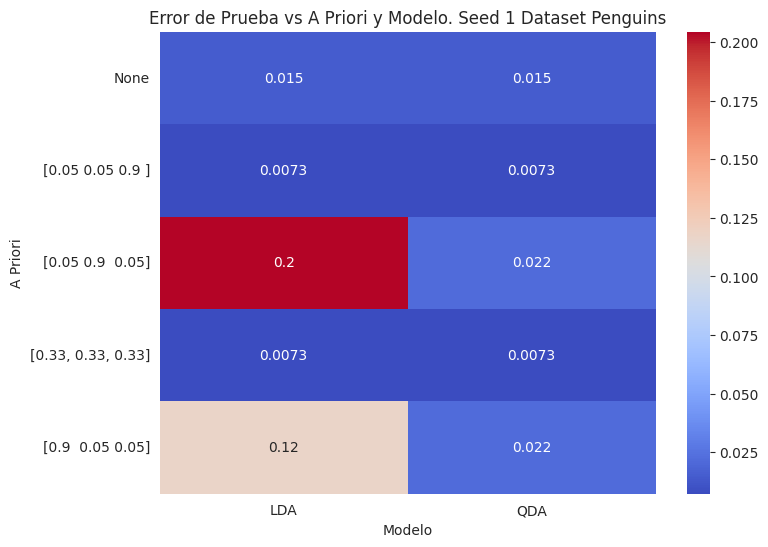

In [17]:
# Convertir los valores de A Priori a cadena para el heatmap
model_runs_result['A Priori'] = model_runs_result['A Priori'].astype(str)

# Crear la matriz pivote para el heatmap
seed = other_seeds[0]
results_penguins_04 = model_runs_result[(model_runs_result['Seed'] == seed) & (model_runs_result['Dataset'] == 'get_iris_dataset')]

heatmap_data = results_penguins_04.pivot_table(values='Error(test)', index='A Priori', columns='Modelo')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title(f"Error de Prueba vs A Priori y Modelo. Seed {seed} Dataset Iris")
plt.show()

# Convertir los valores de A Priori a cadena para el heatmap
model_runs_result['A Priori'] = model_runs_result['A Priori'].astype(str)

# Crear la matriz pivote para el heatmap
results_penguins_04 = model_runs_result[(model_runs_result['Seed'] == seed) & (model_runs_result['Dataset'] == 'get_penguins')]

heatmap_data = results_penguins_04.pivot_table(values='Error(test)', index='A Priori', columns='Modelo')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title(f"Error de Prueba vs A Priori y Modelo. Seed {seed} Dataset Penguins")
plt.show()

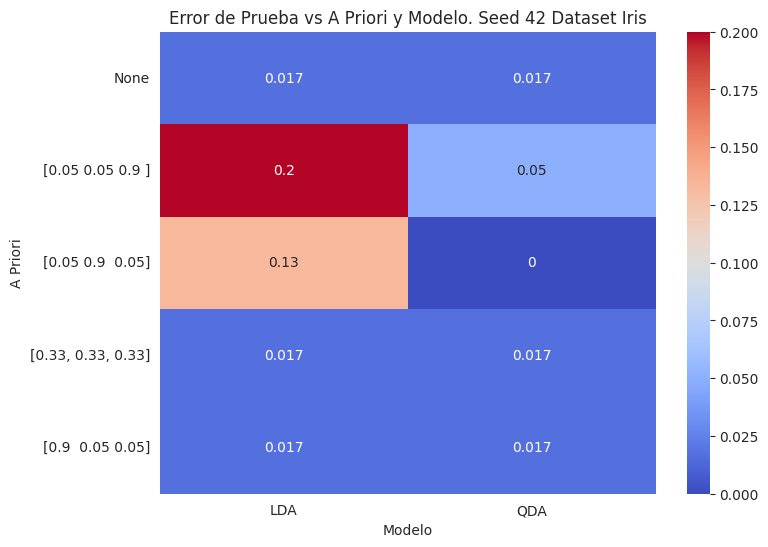

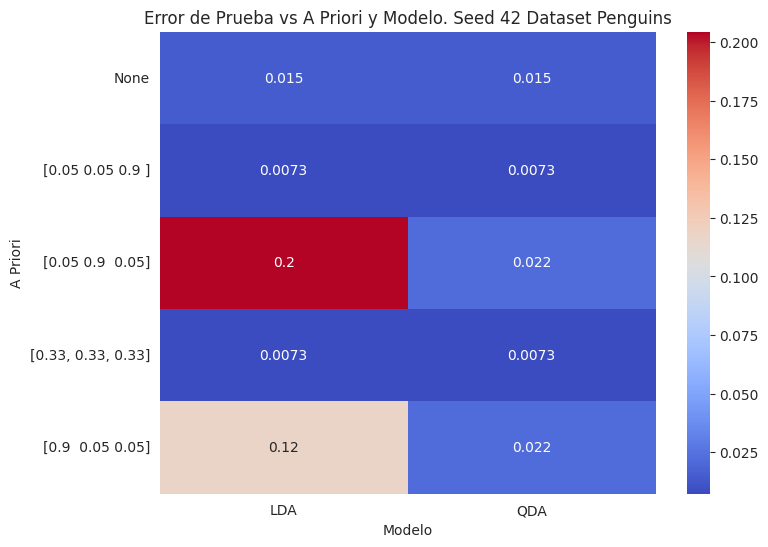

In [18]:
# Convertir los valores de A Priori a cadena para el heatmap
model_runs_result['A Priori'] = model_runs_result['A Priori'].astype(str)

# Crear la matriz pivote para el heatmap
seed = other_seeds[1]
results_penguins_04 = model_runs_result[(model_runs_result['Seed'] == seed) & (model_runs_result['Dataset'] == 'get_iris_dataset')]

heatmap_data = results_penguins_04.pivot_table(values='Error(test)', index='A Priori', columns='Modelo')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title(f"Error de Prueba vs A Priori y Modelo. Seed {seed} Dataset Iris")
plt.show()

# Convertir los valores de A Priori a cadena para el heatmap
model_runs_result['A Priori'] = model_runs_result['A Priori'].astype(str)

# Crear la matriz pivote para el heatmap
results_penguins_04 = model_runs_result[(model_runs_result['Seed'] == seed) & (model_runs_result['Dataset'] == 'get_penguins')]

heatmap_data = results_penguins_04.pivot_table(values='Error(test)', index='A Priori', columns='Modelo')

plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm')
plt.title(f"Error de Prueba vs A Priori y Modelo. Seed {seed} Dataset Penguins")
plt.show()

#### OBSERVACIONES PUNTO 4

- Las conclusiones previas de los puntos 1,2 y 3 se mantienen sin importar la *random seed* utilizada. 

In [19]:

TIMEIT_EXEC_NUMBER = 5000
seconds_to_millis = lambda s: s * 1000

In [20]:

qda_simple = QDA()
qda_simple.fit(train_x, train_y)

faster_qda = TensorizedQDA()
faster_qda.fit(train_x, train_y)


t = timeit.Timer(lambda : accuracy(test_y, faster_qda.predict(test_x)))
repeats = np.array(t.repeat(number=TIMEIT_EXEC_NUMBER))
time_tensorized_qda = seconds_to_millis(repeats.min() / TIMEIT_EXEC_NUMBER)

t = timeit.Timer(lambda : accuracy(test_y, qda_simple.predict(test_x)))
repeats = np.array(t.repeat(number=TIMEIT_EXEC_NUMBER))
time_simple_qda = seconds_to_millis(repeats.min() / TIMEIT_EXEC_NUMBER)


In [21]:
print(f"tensorized: {time_tensorized_qda}ms \nsimple: {time_simple_qda}ms")
print(f"Speedup: {time_simple_qda / time_tensorized_qda}x")


tensorized: 0.8150507982121781ms 
simple: 2.178926967200823ms
Speedup: 2.673363392785236x


#### OBSERVACIONES PUNTO 5

- Se puede ver que la versión tensorizada es casi 3 veces mas rápida que la versión normal. Esto se debe a que la versión tenzorizada hace uso de *hardware* especializado (SIMD) facilitado por escribir el problema con sintaxis tensorial sin cambiar la semántica del código, mediante aplicación de funciones de la librería de *numpy*.

## Optimización matemática

**Sugerencia:** considerar combinaciones adecuadas de `transpose`, `reshape` y, ocasionalmente, `flatten`. Explorar la dimensionalidad de cada elemento antes de implementar las clases.

### QDA

Debido a la forma cuadrática de QDA, no se puede predecir para *n* observaciones en una sola pasada (utilizar $X \in \mathbb{R}^{p \times n}$ en vez de $x \in \mathbb{R}^p$) sin pasar por una matriz de *n x n* en donde se computan todas las interacciones entre observaciones. Se puede acceder al resultado recuperando sólo la diagonal de dicha matriz, pero resulta ineficiente en tiempo y (especialmente) en memoria. Aún así, es *posible* que el modelo funcione más rápido.

1. Implementar el modelo `FasterQDA` (se recomienda heredarlo de TensorizedQDA) de manera de eliminar el ciclo for en el método predict.
2. Comparar los tiempos de predicción de `FasterQDA` con `TensorizedQDA` y `QDA`.
3. Mostrar (puede ser con un print) dónde aparece la mencionada matriz de *n x n*, donde *n* es la cantidad de observaciones a predecir.
4. Demostrar que
$$
diag(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$ es decir, que se puede "esquivar" la matriz de *n x n* usando matrices de *n x p*.
5. Utilizar la propiedad antes demostrada para reimplementar la predicción del modelo `FasterQDA` de forma eficiente. ¿Hay cambios en los tiempos de predicción?


### LDA

1. "Tensorizar" el modelo LDA y comparar sus tiempos de predicción con el modelo antes implementado. *Notar que, en modo tensorizado, se puede directamente precomputar $\mu^T \cdot \Sigma^{-1} \in \mathbb{R}^{k \times 1 \times p}$ y guardar eso en vez de $\Sigma^{-1}$.*
2. LDA no sufre del problema antes descrito de QDA debido a que no computa productos internos, por lo que no tiene un verdadero costo extra en memoria predecir "en batch". Implementar el modelo `FasterLDA` y comparar sus tiempos de predicción con las versiones anteriores de LDA.

#### PUNTO 1 QDA

In [22]:
class FasterQDA(TensorizedQDA):
    def predict(self, X):
        # this is actually an individual prediction encased in a for-loop
        m_obs = X.shape[1]
        y_hat = np.empty(m_obs, dtype=self.encoder.fmt)
        result_tensor = ((X - self.tensor_means).transpose(0,2,1) @ self.tensor_inv_cov @ (X - self.tensor_means))
        results_diag = [[result_tensor[j][obs_idx][obs_idx] for j in range(len(result_tensor))] for obs_idx in range(m_obs)]
        for i in range(m_obs):
          encoded_y_hat_i = np.argmax(self.log_a_priori + (0.5 * np.log(det(self.tensor_inv_cov)) - 0.5 * np.array(results_diag[i])))
          y_hat[i] = self.encoder.names[encoded_y_hat_i]
        
        # return prediction as a row vector (matching y)
        return y_hat.reshape(1,-1)


In [23]:
faster_qda = FasterQDA()
faster_qda.fit(train_x, train_y)

t = timeit.Timer(lambda : accuracy(test_y, faster_qda.predict(test_x)))
repeats = np.array(t.repeat(number=TIMEIT_EXEC_NUMBER))
time_faster_qda = seconds_to_millis(repeats.min() / TIMEIT_EXEC_NUMBER)

In [24]:
print(f"tensorized: {time_tensorized_qda}ms")
print(f"simple: {time_simple_qda}msms")
print(f"faster: {time_faster_qda}msms")
print(f"Speedup simple vs faster: {time_simple_qda / time_faster_qda}x")
print(f"Speedup tensorized vs faster: {time_tensorized_qda / time_faster_qda}x")


tensorized: 0.8150507982121781ms
simple: 2.178926967200823msms
faster: 0.5613104285905137msms
Speedup simple vs faster: 3.881857268663701x
Speedup tensorized vs faster: 1.4520499828567637x


#### PUNTO 2 QDA

- Se ve que la version optimizada de QDA performa 50% mejor que la tensorizada con bucle-for y 4 veces mejor que la simple.

#### PUNTO 3 QDA

La matriz de nxn resulta del siguiente producto interno de la clase FasterQDA
```
result_tensor = ((X - self.tensor_means).transpose(0,2,1) @ self.tensor_inv_cov @ (X - self.tensor_means))
```
En ese caso es un tensor de (3, n, n). Es decir 3 matrices de $n \times n$.

Se puede observar facilmente usando el debugger.
![Matriz de n x n](./n-by-n-matrix.png)


#### Punto 4 QDA:

Se pide demostrar:

$$
\text{diag}(A \cdot B) = \sum_{cols} A \odot B^T = np.sum(A \odot B^T, axis=1)
$$


Primeramente, dada una matriz $C \in \mathbb{R}^{n \times m}$, se define al operador $\text{diag}(\cdot): \mathbb{R}^{n \times m} \rightarrow \mathbb{R}^{\text{min}(n,m)} $:

$$
\begin{align}
\text{diag}(C) &:= \begin{bmatrix}
                    C_{\alpha \alpha}
                \end{bmatrix}  \nonumber \\
                &:=   \begin{bmatrix}
                            C_{11} & C_{22} & ... & C_{kk} 
                \end{bmatrix}   \quad \forall \quad \alpha = 1,2,...,k \; \text{con } k=\text{min}(n,m)
\end{align}
$$

Sean dos matrices cuadradas $A,B \in \mathbb{R}^{n \times n}$, se desarrolla el lado izquierdo (LHS) usando notación indicial o de Einstein, salvo indicación:

$$
\text{diag}(A \cdot B) = \text{diag}(A_{\alpha \beta} B_{\beta \gamma}) = \begin{bmatrix} A_{\alpha \beta} B_{\beta \alpha} \end{bmatrix}  \quad \forall  \quad \alpha,\beta = 1,2,...,n \quad \text{(no suma en } \alpha \text{ )}
$$
Desarrollando el lado derecho (RHS) de la expresión a demostrar:

$$
\begin{align}
\sum_{cols} A \odot B^T &= \sum_{cols} A_{\alpha \beta} \odot (B_{\alpha \beta})^T   \nonumber \\
                        &= \sum_{cols} A_{\alpha \beta} \odot B_{\beta \alpha}  \quad \text{(no suma en } \alpha,\beta \text{ )} \nonumber
\end{align}
$$                    

donde el operador $\odot$ representa la multiplicación elemento a elemento. Los subíndices $\alpha,\beta$ están asociados a las filas y columnas, respectivamente, de la matriz resultante de la multiplicación elemento a elemento.

Tomando la sumatoria sobre el índice $\beta$ correspondiente a las columnas:

$$
\begin{align}
\sum_{cols} A \odot B^T &= \sum_{\beta} A_{\alpha \beta} B_{\beta \alpha} \nonumber \\
                        &= [A_{\alpha \beta} B_{\beta \alpha}]\quad \text{(no suma en } \alpha \text{ )} \nonumber
\end{align}
$$     

La expresión $np.sum(A \odot B^T, axis=1)$ representa la implementación de la expresión del RHS haciendo uso de la función *sum* de *numpy*, donde el argumento *axis* denota el índice sobre el cual se lleva a cabo la sumatoria, en este caso, *axis=1* implica, por cada fila (*axis=0*), la suma de todos los elementos de cada columna. En caso de no especificarse, por *default* se suma sobre todos los elementos del *array*.

**Por lo tanto, se verifica la igualdad.**

#### Punto 5 QDA:

In [25]:
class EvenFasterQDA(FasterQDA):
    def predict(self, X):
        # this is actually an individual prediction encased in a for-loop
        m_obs = X.shape[1]
        y_hat = np.empty(m_obs, dtype=self.encoder.fmt)
        B = self.tensor_inv_cov @ (X - self.tensor_means)
        A = (X - self.tensor_means).transpose(0, 2, 1)
        
        results_diag_2 = np.sum(A * B.transpose(0, 2, 1), axis = 2).T
        for i in range(m_obs):
          encoded_y_hat_i = np.argmax(self.log_a_priori + (0.5 * np.log(det(self.tensor_inv_cov)) - 0.5 * np.array(results_diag_2[i])))
          y_hat[i] = self.encoder.names[encoded_y_hat_i]
        
        # return prediction as a row vector (matching y)
        return y_hat.reshape(1,-1)    
    


In [26]:
faster_qda = FasterQDA()
faster_qda.fit(train_x, train_y)

even_faster_qda = EvenFasterQDA()
even_faster_qda.fit(train_x, train_y)
(faster_qda.predict(test_x) == faster_qda.predict(test_x)).all()
print("EvenFasterQDA es equivalente a FasterQDA:", (faster_qda.predict(train_x) == even_faster_qda.predict(train_x)).all())


EvenFasterQDA es equivalente a FasterQDA: True


In [27]:

t = timeit.Timer(lambda: accuracy(test_y, faster_qda.predict(test_x)))
repeats = np.array(t.repeat(number=TIMEIT_EXEC_NUMBER))
time_faster_qda = seconds_to_millis(repeats.min() / TIMEIT_EXEC_NUMBER)

t = timeit.Timer(lambda: accuracy(test_y, even_faster_qda.predict(test_x)))
repeats = np.array(t.repeat(number=TIMEIT_EXEC_NUMBER))
time_even_faster_qda = seconds_to_millis(repeats.min() / TIMEIT_EXEC_NUMBER)

print(f"FasterQDA: {time_faster_qda}ms \nEvenFasterQDA: {time_even_faster_qda}ms")
print(f"Speedup: {time_faster_qda / time_even_faster_qda}x")

FasterQDA: 0.5646253843791782ms 
EvenFasterQDA: 0.5112324418034404ms
Speedup: 1.1044396603380393x


#### OBSERVACIONES Punto 5 QDA

Se logro una mejora del 10% en performance.

#### Punto 1 LDA:

In [28]:

class TensorizedLDA(LDA):
    def _fit_params(self, X, y):
        super()._fit_params(X, y)
        self.inv_covs_tensor = np.stack(self.inv_covs)
        self.means_tensor = np.stack(self.means)
    def _predict_log_conditionals(self, x):
        # predict the log(P(x|G=class_idx)), the log of the conditional probability of x given the class
        # this should depend on the model used
        return self.means_tensor.transpose(0,2,1) @ self.inv_covs_tensor @ (x - 0.5 * self.means_tensor)
    def _predict_one(self, x):
        # return the class that has maximum a posteriori probability
        return np.argmax(self.log_a_priori + self._predict_log_conditionals(x).flatten())

class FasterLDA(TensorizedLDA):
    def predict(self, X):
        # this is actually an individual prediction encased in a for-loop
        m_obs = X.shape[1]
        y_hat = np.empty(m_obs, dtype=self.encoder.fmt)
        results = (self.means_tensor.transpose(0,2,1) @ self.inv_covs_tensor @ (X - 0.5 * self.means_tensor)).transpose(1, 2, 0)[0]
        for i in range(len(results)):
          max_class = np.argmax(self.log_a_priori + results[i])
          y_hat[i] = self.encoder.names[max_class]
    
        # return prediction as a row vector (matching y)
        return y_hat.reshape(1,-1)

In [29]:
X_full, y_full = get_iris_dataset()

train_x, train_y, test_x, test_y = split_transpose(X_full, y_full, 0.4, 6543)

faster_qda = TensorizedQDA()
faster_qda.fit(train_x, train_y)

qda_faster = FasterQDA()
qda_faster.fit(train_x, train_y)
qda_faster.predict(train_x)
print("FasterQDA es equivalente a QDA:", (qda_faster.predict(train_x) == faster_qda.predict(train_x)).all())


FasterQDA es equivalente a QDA: True


In [30]:
x_full, y_full = get_penguins()
train_x, train_y, test_x, test_y = split_transpose(x_full, y_full, 0.4, rng_seed)

tensorized_lda = TensorizedLDA()
a_priori=np.array([0.33,0.33,0.33])
tensorized_lda.fit(train_x, train_y, a_priori=a_priori)

faster_lda = FasterLDA()
a_priori=np.array([0.33,0.33,0.33])
faster_lda.fit(train_x, train_y, a_priori=a_priori)
print("TensorizedLDA es equivalente a LDA:", (tensorized_lda.predict(train_x) == faster_lda.predict(train_x)).all())

TensorizedLDA es equivalente a LDA: True


In [31]:
%%timeit
train_acc = accuracy(train_y, tensorized_lda.predict(train_x))


1.57 ms ± 13.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [32]:
x_full, y_full = get_penguins()
train_x, train_y, test_x, test_y = split_transpose(x_full, y_full, 0.4, rng_seed)

lda = LDA()
a_priori=np.array([0.33,0.33,0.33])
lda.fit(train_x, train_y, a_priori=a_priori)

In [33]:
%%timeit
train_acc = accuracy(train_y, lda.predict(train_x))

4.35 ms ± 725 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [34]:
lda_simple = LDA()
lda_simple.fit(train_x, train_y)

tensorized_lda = TensorizedLDA()
tensorized_lda.fit(train_x, train_y)

t = timeit.Timer(lambda: accuracy(test_y, tensorized_lda.predict(test_x)))
repeats = np.array(t.repeat(number=TIMEIT_EXEC_NUMBER))
time_tensorized_lda = seconds_to_millis(repeats.min() / TIMEIT_EXEC_NUMBER)

t = timeit.Timer(lambda: accuracy(test_y, lda_simple.predict(test_x)))
repeats = np.array(t.repeat(number=TIMEIT_EXEC_NUMBER))
time_simple_lda = seconds_to_millis(repeats.min() / TIMEIT_EXEC_NUMBER)

print(f"tensorized: {time_tensorized_lda}ms \nsimple: {time_simple_lda}ms")
print(f"Speedup: {time_simple_lda / time_tensorized_lda}x")

tensorized: 1.0631786230020226ms 
simple: 2.614977224799804ms
Speedup: 2.4595840889050957x


#### Punto 2 LDA
De nuevo se puede ver que la version tensorizada de LDA es mas rápida que la no tensorizada (2.46 veces más rápida). 

## Preguntas teóricas

1. En LDA se menciona que la función a maximizar puede ser, mediante operaciones, convertida en:
$$
\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'
$$
Mostrar los pasos por los cuales se llega a dicha expresión.

2. Explicar, utilizando las respectivas funciones a maximizar, por qué QDA y LDA son "quadratic" y "linear".

3. La implementación de QDA estima la probabilidad condicional utilizando `0.5*np.log(det(inv_cov)) -0.5 * unbiased_x.T @ inv_cov @ unbiased_x` que no es *exactamente* lo descrito en el apartado teórico ¿Cuáles son las diferencias y por qué son expresiones equivalentes?

El espíritu de esta componente práctica es la de establecer un mínimo de trabajo aceptable para su entrega; se invita al alumno a explorar otros aspectos que generen curiosidad, sin sentirse de ninguna manera limitado por la consigna.

#### Punto 1

Partimos de la expresión general para LDA:

$$
\log{f_j(x)} =  -\frac{1}{2}\log |\Sigma| - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C
$$

donde $C=-\frac{p}{2} \log(2\pi)$.

Como se mecionó más arriba $-\frac{1}{2}\log |\Sigma|$ es común a todas las clases y, por lo tanto, se puede incorporar a la constante aditiva. De este modo, nos queda:

$$
\log{f_j(x)} =  - \frac{1}{2} (x-\mu_j)^T \Sigma^{-1} (x- \mu_j) + C_1
$$

donde $C_1=-\frac{p}{2} \log(2\pi)-\frac{1}{2}\log |\Sigma|$.

Re-escribiendo el lado derecho (RHS) en notación indicial o de Einstein:

$$
\log{f_j(x)} =  - \frac{1}{2} \Big(x_\alpha-(\mu_j)_\alpha \Big) \; (\Sigma^{-1})_{\alpha \beta} \; \Big(x_\beta - (\mu_j)_\beta \Big) + C_1 \quad \forall  \quad \alpha,\beta = 1,2,...,n
$$

Distribuyendo:

$$
\begin{align}
   \log{f_j(x)} &=  - \frac{1}{2} \; x_\alpha \; (\Sigma^{-1})_{\alpha \beta} \; x_\beta 
                        + \frac{1}{2} \; x_\alpha \; (\Sigma^{-1})_{\alpha \beta} \; (\mu_j)_\beta \nonumber \\ 
                &\qquad + \frac{1}{2} \; (\mu_j)_\alpha \; (\Sigma^{-1})_{\alpha \beta} \; x_\beta
                        - \frac{1}{2} \; (\mu_j)_\alpha \; (\Sigma^{-1})_{\alpha \beta} \; (\mu_j)_\beta + C_1 \nonumber
\end{align}
$$

Algunas consideraciones:

- El 1° término del RHS, cómo es común a todas las clases, se puede considerar como una constante aditiva que no afecta al cálculo del máximo.

- La matriz de covarianzas es simétrica por definición, es decir, $(\Sigma^{-1})_{\alpha \beta} = (\Sigma^{-1})_{\beta \alpha}$. Por lo tanto, el 2° término puede re-escribirse como:

$$
x_\alpha \; (\Sigma^{-1})_{\alpha \beta} \; (\mu_j)_\beta = x_\alpha \; (\Sigma^{-1})_{\beta  \alpha} \; (\mu_j)_\beta
$$

- Como los índices $\alpha,\beta$ en la expresión anterior están en suma, resulta válido intercambiarlos ya que son índices *dummies*:

$$
x_\alpha \; (\Sigma^{-1})_{\beta  \alpha} \; (\mu_j)_\beta = x_\beta \; (\Sigma^{-1})_{\alpha  \beta} \; (\mu_j)_\alpha
$$

Entonces, se tiene:

$$
\begin{align}
   \log{f_j(x)} &=  \frac{1}{2} \; x_\beta \; (\Sigma^{-1})_{\alpha  \beta} \; (\mu_j)_\alpha 
                    + \frac{1}{2} \; (\mu_j)_\alpha \; (\Sigma^{-1})_{\alpha \beta} \; x_\beta\nonumber \\ 
                &\qquad - \frac{1}{2} \; (\mu_j)_\alpha \; (\Sigma^{-1})_{\alpha \beta} \; (\mu_j)_\beta +C_2 \nonumber
\end{align}
$$

donde $C_2=-\frac{p}{2} \log(2\pi)-\frac{1}{2}\log |\Sigma|-\frac{1}{2} \; x_\alpha \; (\Sigma^{-1})_{\alpha \beta} \; x_\beta $.

Re-agrupando:

$$
\begin{align}
   \log{f_j(x)} &=  (\mu_j)_\alpha  \; (\Sigma^{-1})_{\alpha  \beta} \; x_\beta
                    - \frac{1}{2} \; (\mu_j)_\alpha \; (\Sigma^{-1})_{\alpha \beta} \; (\mu_j)_\beta + C_2 \nonumber
\end{align}
$$

Re-escribiendo en forma matricial y tomando $\mu_j$ como factor común, finalmente se obtiene la expresió deseada:

$$
\boxed{
\begin{align}
   \log{f_j(x)} &= \mu_j^T  \cdot \Sigma^{-1} \cdot \Big(x
                    - \frac{1}{2} \; \mu_j \Big) + C_2 \nonumber
\end{align}
}
$$

#### Punto 2

Se tiene:

| Modelo    | Función a Máximizar                                                                               |
|---------- |---------------------------------------------------------------------------------------------------|
| QDA       | $\log{f_j(x)} = -\frac{1}{2} \log{\| \Sigma_j \|}-\frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x-\mu_j) + C$    |
| LDA       | $\log{f_j(x)} =  \mu_j^T \Sigma^{-1} (x- \frac{1}{2} \mu_j) + C'$                                 |

Se observa que función del modelo QDA es cuádratica en el arreglo de atributos o *features* $x$, mientras que en LDA, es lineal.


#### Punto 3

Se parte de la expresión dada en la parte teórica:

$$
f_j(x) = \frac{1}{(2 \pi)^\frac{p}{2} \cdot |\Sigma_j|^\frac{1}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Para una matriz $A$, cuadrada e invertible (*i.e.*, su determinante es distinto de cero), se tiene la siguiente propiedad:

$$
\det (A) = \frac {1}{\det (A^{-1})}
$$

Por lo tanto, se tiene:

$$
f_j(x) = \frac{|\Sigma_j^{-1}|^\frac{1}{2}}{(2 \pi)^\frac{p}{2}} e^{- \frac{1}{2}(x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j)}
$$

Tomando el logaritmo:

$$
\log{f_j(x)} = \frac{1}{2}\log |\Sigma_j^{-1}| - \frac{1}{2} (x-\mu_j)^T \Sigma_j^{-1} (x- \mu_j) + C
$$

Se demuestra que la expresión implementada es equivalente a la expresión del apartado teórico.

## Ejercicio teórico

Sea una red neuronal de dos capas, la primera de 3 neuronas y la segunda de 1 con los parámetros inicializados con los siguientes valores:
$$
w^{(1)} =
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix},
b^{(1)} = \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix},
w^{(2)} =
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix},
b^{(2)} = 0.7
$$

y donde cada capa calcula su salida vía

$$
y^{(i)} = \sigma (w^{(i)} \cdot x^{(i)}+b^{(i)})
$$

donde $\sigma (z) = \frac{1}{1+e^{-z}}$ es la función sigmoidea .

\\
Dada la observación $x=\begin{pmatrix}
1.8 \\
-3.4
\end{pmatrix}$, $y=5$ y la función de costo $J(\theta)=\frac{1}{2}(\hat{y}_\theta-y)^2$, calcular las derivadas de J respecto de cada parámetro $w^{(1)}$, $w^{(2)}$, $b^{(1)}$, $b^{(2)}$.

*Nota: Con una sigmoidea a la salida jamás va a poder estimar el 5 "pedido", pero eso no afecta al mecanismo de backpropagation!*

Parámetros iniciales:

$$
w^{(1)} =
\begin{pmatrix}
0.1 & -0.5 \\
-0.3 & -0.9 \\
0.8 & 0.02
\end{pmatrix},
\quad
b^{(1)} = \begin{pmatrix}
0.1 \\
0.5 \\
0.8
\end{pmatrix},
\quad
w^{(2)} =
\begin{pmatrix}
-0.4 & 0.2 & -0.5
\end{pmatrix},
\quad
b^{(2)} = 0.7
$$

Entrada y salida deseada:

$$
x = \begin{pmatrix} 1.8 \\ -3.4 \end{pmatrix}, \quad y = 5
$$

Función sigmoidea:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Propagación hacia adelante (Forward Propagation):

1. Capa 1:
   $$
   z^{(1)} = w^{(1)} \cdot x + b^{(1)} = 
   \begin{pmatrix} 1.98 \\ 3.02 \\ 2.172 \end{pmatrix}
   $$
   $$
   a^{(1)} = \sigma(z^{(1)}) = 
   \begin{pmatrix} 0.878 \\ 0.953 \\ 0.897 \end{pmatrix}
   $$

2. Capa 2:
   $$
   z^{(2)} = w^{(2)} \cdot a^{(1)} + b^{(2)} = 0.0904
   $$
   $$
   a^{(2)} = \sigma(z^{(2)}) = 0.523
   $$

Costo:

$$
J(\theta) = \frac{1}{2}(\hat{y}_\theta - y)^2 = \frac{1}{2}(0.523 - 5)^2 \approx 10.02
$$


### Derivadas de la función de costo con respecto a los parámetros

Derivada respecto a $w^{(2)}$:

Sabemos que:

$$
\hat{y}_\theta = \sigma(w^{(2)} \cdot \sigma(w^{(1)} \cdot x + b^{(1)}) + b^{(2)})
$$

Aplicando la regla de la cadena:

$$
\frac{\partial J}{\partial w^{(2)}} = \frac{\partial J}{\partial \hat{y}_\theta} \cdot \frac{\partial \hat{y}_\theta}{\partial w^{(2)}}
$$

Donde:

$$
\frac{\partial J}{\partial \hat{y}_\theta} = \hat{y}_\theta - y = 0.523 - 5 = -4.477
$$

Y:

$$
\frac{\partial \hat{y}_\theta}{\partial w^{(2)}} = \sigma'(w^{(2)} \cdot \sigma(w^{(1)} \cdot x + b^{(1)}) + b^{(2)}) \cdot \sigma(w^{(1)} \cdot x + b^{(1)})
$$

Sabemos que:

$$
\sigma'(z) = \sigma(z)(1 - \sigma(z))
$$

Por lo tanto:

$$
\frac{\partial \hat{y}_\theta}{\partial w^{(2)}} = 0.523(1 - 0.523) \cdot \begin{pmatrix} 0.878 \\ 0.953 \\ 0.897 \end{pmatrix} \approx \begin{pmatrix} 0.219 \\ 0.238 \\ 0.224 \end{pmatrix}
$$

Entonces:

$$
\frac{\partial J}{\partial w^{(2)}} = -4.477 \cdot \begin{pmatrix} 0.219 \\ 0.238 \\ 0.224 \end{pmatrix} \approx \begin{pmatrix} -0.981 \\ -1.065 \\ -1.003 \end{pmatrix}
$$

Derivada respecto a $b^{(2)}$:

$$
\frac{\partial J}{\partial b^{(2)}} = \frac{\partial J}{\partial \hat{y}_\theta} \cdot \frac{\partial \hat{y}_\theta}{\partial b^{(2)}}
$$

Donde:

$$
\frac{\partial \hat{y}_\theta}{\partial b^{(2)}} = \sigma'(w^{(2)} \cdot \sigma(w^{(1)} \cdot x + b^{(1)}) + b^{(2)}) = 0.523(1 - 0.523) \approx 0.249
$$

Por lo tanto:

$$
\frac{\partial J}{\partial b^{(2)}} = -4.477 \cdot 0.249 \approx -1.117
$$

Derivada respecto a $w^{(1)}$:

Aplicando la regla de la cadena:

$$
\frac{\partial J}{\partial w^{(1)}} = \frac{\partial J}{\partial \hat{y}_\theta} \cdot \frac{\partial \hat{y}_\theta}{\partial \sigma(w^{(1)} \cdot x + b^{(1)})} \cdot \frac{\partial \sigma(w^{(1)} \cdot x + b^{(1)})}{\partial w^{(1)}}
$$

Calculamos:

$$
\frac{\partial \sigma(w^{(1)} \cdot x + b^{(1)})}{\partial w^{(1)}} = \sigma'(w^{(1)} \cdot x + b^{(1)}) \cdot x
$$

Donde:

$$
\sigma'(w^{(1)} \cdot x + b^{(1)}) = \begin{pmatrix} 0.107 \\ 0.044 \\ 0.092 \end{pmatrix}
$$

Entonces:

$$
\frac{\partial \sigma(w^{(1)} \cdot x + b^{(1)})}{\partial w^{(1)}} = \begin{pmatrix} 0.107 \\ 0.044 \\ 0.092 \end{pmatrix} \cdot \begin{pmatrix} 1.8 \\ -3.4 \end{pmatrix} = \begin{pmatrix} 0.191 & -0.362 \\ 0.079 & -0.151 \\ 0.165 & -0.312 \end{pmatrix}
$$

Finalmente:

$$
\frac{\partial J}{\partial w^{(1)}} = -4.477 \cdot \begin{pmatrix} 0.191 & -0.362 \\ 0.079 & -0.151 \\ 0.165 & -0.312 \end{pmatrix} \approx \begin{pmatrix} -0.859 & 1.623 \\ -0.357 & 0.675 \\ -0.740 & 1.398 \end{pmatrix}
$$

Derivada respecto a $b^{(1)}$:

$$
\frac{\partial J}{\partial b^{(1)}} = \frac{\partial J}{\partial \hat{y}_\theta} \cdot \frac{\partial \hat{y}_\theta}{\partial \sigma(w^{(1)} \cdot x + b^{(1)})} \cdot \sigma'(w^{(1)} \cdot x + b^{(1)})
$$

Ya hemos calculado:

$$
\sigma'(w^{(1)} \cdot x + b^{(1)}) = \begin{pmatrix} 0.107 \\ 0.044 \\ 0.092 \end{pmatrix}
$$

Entonces:

$$
\frac{\partial J}{\partial b^{(1)}} = -4.477 \cdot \begin{pmatrix} 0.107 \\ 0.044 \\ 0.092 \end{pmatrix} \approx \begin{pmatrix} -0.477 \\ -0.199 \\ -0.411 \end{pmatrix}
$$



## Preguntas en el código
Previamente las preguntas "técnicas" en comentarios en el código eran parte del TP, y buscaban que el alumno logre entrar en el detalle de por qué cada linea de código es como es y en el orden en el que está. Ya no forman parte de la consigna, pero se aconseja al alumno intentar responderlas. Las respuestas a las mismas se encuentran en un archivo separado.